# Assignment 3 - Task 1: Data Preprocessing & EDA

## Objective
Load, clean, preprocess, and explore the Financial Phrase Bank dataset for sentiment analysis.

---

## Step 1: Import Required Libraries


In [ ]:
# Standard library imports
import os
import re
import random
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


In [ ]:
# Download required NLTK data
# Note: Newer NLTK versions (3.8+) require 'punkt_tab' instead of just 'punkt'
print("Downloading required NLTK data...")
print("(This may take a moment on first run)\n")

# Download punkt_tab (required for newer NLTK versions in Colab)
try:
    nltk.data.find('tokenizers/punkt_tab')
    print("✓ punkt_tab tokenizer already available")
except LookupError:
    print("Downloading punkt_tab tokenizer (required for NLTK 3.8+)...")
    try:
        nltk.download('punkt_tab', quiet=True)
        print("✓ punkt_tab tokenizer downloaded successfully")
    except Exception as e:
        print(f"⚠ Warning: Could not download punkt_tab: {e}")

# Also download punkt (for compatibility with older NLTK versions)
try:
    nltk.data.find('tokenizers/punkt')
    print("✓ punkt tokenizer already available")
except LookupError:
    try:
        nltk.download('punkt', quiet=True)
        print("✓ punkt tokenizer downloaded")
    except:
        pass  # Not critical if punkt_tab is available

# Download stopwords
try:
    nltk.data.find('corpora/stopwords')
    print("✓ stopwords already available")
except LookupError:
    print("Downloading stopwords...")
    nltk.download('stopwords', quiet=True)
    print("✓ stopwords downloaded")

# Verify tokenizer works
print("\nVerifying tokenizer...")
try:
    from nltk.tokenize import word_tokenize
    test_text = "This is a test."
    tokens = word_tokenize(test_text)
    print(f"✓ Tokenizer working correctly (test: {tokens})")
except Exception as e:
    print(f"⚠ Warning: Tokenizer test failed: {e}")
    print("   Trying to download punkt_tab again...")
    try:
        nltk.download('punkt_tab', quiet=False)  # Show progress this time
        print("✓ punkt_tab downloaded. Please re-run this cell if needed.")
    except Exception as e2:
        print(f"⚠ Error downloading punkt_tab: {e2}")

print("\n" + "="*60)
print("✓ NLTK data setup complete!")
print("="*60)


(This may take a moment on first run)

✓ punkt_tab tokenizer downloaded successfully
✓ punkt tokenizer downloaded
✓ stopwords downloaded

Verifying tokenizer...
✓ Tokenizer working correctly (test: ['This', 'is', 'a', 'test', '.'])

✓ NLTK data setup complete!


In [ ]:
# Install additional packages if needed (for Google Colab compatibility)
# Colab usually has these, but this ensures they're available
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
        print(f"✓ {package} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f"✓ {package} installed successfully")

# Check and install seaborn if needed
install_package('seaborn')

# Re-import to ensure it's available
import seaborn as sns
print("All packages ready!")


✓ seaborn is already installed
All packages ready!


## Step 2: Upload and Extract Dataset

### 2.1 Upload dataset.zip file

**For Google Colab:** Upload your `dataset.zip` file using the file uploader below.

**Alternative:** If you have the dataset on Google Drive, you can mount Google Drive instead.


In [ ]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("✓ Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("✓ Running in local Jupyter environment")

import os
import zipfile

# Show current working directory
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# If in Colab, use file uploader. Otherwise, assume file exists locally
if IN_COLAB:
    from google.colab import files

    print("\n" + "="*80)
    print("UPLOAD DATASET")
    print("="*80)
    print(f"\nWorking directory: {current_dir}")
    print("Please upload your 'dataset.zip' file when prompted...")

    # Upload file
    uploaded = files.upload()

    # Get the uploaded filename
    zip_filename = list(uploaded.keys())[0] if uploaded else None

    if zip_filename and zip_filename.endswith('.zip'):
        zip_path = os.path.join(current_dir, zip_filename)
        extract_path = current_dir  # Extract to current directory (usually /content in Colab)

        # Extract the zip file
        print(f"\nExtracting {zip_filename} to: {extract_path}")
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"✓ Dataset extracted successfully to: {extract_path}")

        # Verify extraction
        expected_path = os.path.join(extract_path, 'FinancialPhraseBank-v1.0', 'Sentences_AllAgree.txt')
        if os.path.exists(expected_path):
            print(f"✓ Verified: Dataset file exists at: {expected_path}")
        else:
            print(f"⚠️ Warning: Expected file not found at: {expected_path}")
            print("Listing extracted contents:")
            if os.path.exists(os.path.join(extract_path, 'FinancialPhraseBank-v1.0')):
                print(os.listdir(os.path.join(extract_path, 'FinancialPhraseBank-v1.0')))
    else:
        print("⚠️ No zip file uploaded. Please make sure to upload 'dataset.zip'")
else:
    # Running locally - check if dataset folder exists
    zip_file = 'dataset.zip'
    dataset_folder = 'FinancialPhraseBank-v1.0'

    if os.path.exists(zip_file) and not os.path.exists(dataset_folder):
        print(f"\nExtracting {zip_file} to: {current_dir}")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(current_dir)
        print(f"✓ Dataset extracted successfully to: {current_dir}")

        # Verify extraction
        expected_path = os.path.join(current_dir, dataset_folder, 'Sentences_AllAgree.txt')
        if os.path.exists(expected_path):
            print(f"✓ Verified: Dataset file exists at: {expected_path}")
    elif os.path.exists(dataset_folder):
        expected_path = os.path.join(current_dir, dataset_folder, 'Sentences_AllAgree.txt')
        if os.path.exists(expected_path):
            print(f"✓ Dataset folder already exists at: {dataset_folder}")
            print(f"✓ Dataset file exists at: {expected_path}")
        else:
            print(f"⚠️ Dataset folder exists but file not found at: {expected_path}")
    else:
        print(f"⚠️ Please ensure 'dataset.zip' is in: {current_dir}")
        print(f"Current directory contents: {os.listdir('.')[:5]}")


✓ Running in Google Colab
Current working directory: /content

UPLOAD DATASET

Working directory: /content
Please upload your 'dataset.zip' file when prompted...


Saving dataset.zip to dataset.zip

Extracting dataset.zip to: /content
✓ Dataset extracted successfully to: /content
✓ Verified: Dataset file exists at: /content/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt


### 2.2 Alternative: Mount Google Drive

If you prefer to store your dataset on Google Drive, you can use this option instead:


In [ ]:
# OPTIONAL: Mount Google Drive
# Uncomment the code below if you want to load dataset from Google Drive instead

# if IN_COLAB:
#     from google.colab import drive
#     drive.mount('/content/drive')
#
#     # Update the dataset path if using Drive
#     # dataset_path = '/content/drive/MyDrive/path/to/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt'

print("If using Google Drive, uncomment the code above and update the path accordingly.")


### 2.3 Load Dataset

The Financial Phrase Bank dataset contains financial sentences annotated with sentiment labels (positive, neutral, negative).

We'll use the `Sentences_AllAgree.txt` file which contains sentences with 100% annotator agreement.


In [ ]:
# Load dataset - automatically detect path for Colab or local environment
import os

# Show current working directory
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")
print(f"Current directory contents: {os.listdir('.')[:10]}...")  # Show first 10 items

# Define possible dataset paths
possible_paths = [
    'FinancialPhraseBank-v1.0/Sentences_AllAgree.txt',  # Relative path (local/Colab after extraction)
    '/content/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt',  # Colab absolute path
    os.path.join(current_dir, 'FinancialPhraseBank-v1.0', 'Sentences_AllAgree.txt'),  # Absolute path
]

# Try to find the dataset file
dataset_path = None
for path in possible_paths:
    if os.path.exists(path):
        dataset_path = path
        print(f"\n✓ Found dataset file at: {dataset_path}")
        break

# If still not found, search recursively
if dataset_path is None:
    print("\n⚠️ Dataset file not found in standard locations. Searching...")
    for root, dirs, files in os.walk('.'):
        if 'Sentences_AllAgree.txt' in files:
            dataset_path = os.path.join(root, 'Sentences_AllAgree.txt')
            print(f"✓ Found dataset file at: {dataset_path}")
            break

# Load the dataset if found
if dataset_path is None:
    print("\n" + "="*80)
    print("ERROR: Dataset file not found!")
    print("="*80)
    print("Please make sure you've:")
    print("1. Uploaded 'dataset.zip' file")
    print("2. Extracted it successfully")
    print("3. The file 'FinancialPhraseBank-v1.0/Sentences_AllAgree.txt' exists")
    print("\nCurrent directory structure:")
    for root, dirs, files in os.walk('.', topdown=True):
        level = root.replace('.', '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files in each directory
            print(f"{subindent}{file}")
else:
    # Try different encodings if needed
    encodings = ['latin-1', 'utf-8', 'cp1252']

    data = []
    for encoding in encodings:
        try:
            with open(dataset_path, 'r', encoding=encoding) as f:
                for line in f:
                    if '@' in line:
                        parts = line.strip().split('@', 1)
                        if len(parts) == 2:
                            data.append({
                                'sentence': parts[0],
                                'sentiment': parts[1]
                            })
            print(f"✓ Successfully loaded dataset using {encoding} encoding")
            break
        except Exception as e:
            continue

    # Create DataFrame
    df = pd.DataFrame(data)

    print(f"\n{'='*80}")
    print("DATASET LOADED SUCCESSFULLY!")
    print(f"{'='*80}")
    print(f"Dataset path: {dataset_path}")
    print(f"Total number of sentences: {len(df)}")
    print(f"Dataset shape: {df.shape}")
    print(f"\nFirst 10 rows:")
    display(df.head(10))


Current working directory: /content
Current directory contents: ['.config', 'FinancialPhraseBank-v1.0', 'dataset.zip', 'sample_data']...

✓ Found dataset file at: FinancialPhraseBank-v1.0/Sentences_AllAgree.txt
✓ Successfully loaded dataset using latin-1 encoding

DATASET LOADED SUCCESSFULLY!
Dataset path: FinancialPhraseBank-v1.0/Sentences_AllAgree.txt
Total number of sentences: 2264
Dataset shape: (2264, 2)

First 10 rows:


,sentence,sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive
5,Finnish Talentum reports its operating profit ...,positive
6,Clothing retail chain Sepp+ñl+ñ 's sales incre...,positive
7,Consolidated net sales increased 16 % to reach...,positive
8,Foundries division reports its sales increased...,positive
9,"HELSINKI ( AFX ) - Shares closed higher , led ...",positive


### Dataset Path Summary

This cell shows all the paths being used, which is helpful for debugging in Colab:


In [ ]:
# Display path information for reference
print("="*80)
print("PATH INFORMATION SUMMARY")
print("="*80)
print(f"\nCurrent working directory: {os.getcwd()}")

# Check if dataset was loaded
try:
    if 'dataset_path' in locals() or 'dataset_path' in globals():
        path = locals().get('dataset_path') or globals().get('dataset_path')
        if path and os.path.exists(path):
            print(f"\n✓ Dataset file path: {path}")
            print(f"✓ Dataset file exists: Yes")

            file_size = os.path.getsize(path)
            print(f"  File size: {file_size:,} bytes ({file_size/1024:.2f} KB)")

            # Show parent directory
            dataset_dir = os.path.dirname(path)
            print(f"\nDataset directory: {dataset_dir}")
            if os.path.exists(dataset_dir):
                files_in_dir = os.listdir(dataset_dir)
                print(f"Files in dataset directory ({len(files_in_dir)} total):")
                for f in files_in_dir[:10]:  # Show first 10 files
                    file_path = os.path.join(dataset_dir, f)
                    if os.path.isfile(file_path):
                        size = os.path.getsize(file_path)
                        print(f"  📄 {f} ({size:,} bytes)")
                    else:
                        print(f"  📁 {f}/")
        else:
            print("\n⚠️ Dataset path variable exists but file not found.")
    elif 'df' in locals() or 'df' in globals():
        print("\n✓ Dataset DataFrame loaded successfully!")
        print("  (Path information available in previous cell output)")
    else:
        print("\n⚠️ Please run the dataset loading cell first.")
except Exception as e:
    print(f"\nNote: {e}")
    print("(This is normal if dataset hasn't been loaded yet)")

print("\n" + "="*80)


PATH INFORMATION SUMMARY

Current working directory: /content

✓ Dataset file path: FinancialPhraseBank-v1.0/Sentences_AllAgree.txt
✓ Dataset file exists: Yes
  File size: 299,636 bytes (292.61 KB)

Dataset directory: FinancialPhraseBank-v1.0
Files in dataset directory (6 total):
  📄 Sentences_66Agree.txt (580,254 bytes)
  📄 Sentences_75Agree.txt (466,991 bytes)
  📄 README.txt (4,013 bytes)
  📄 Sentences_AllAgree.txt (299,636 bytes)
  📄 Sentences_50Agree.txt (671,355 bytes)
  📄 License.txt (394 bytes)



In [ ]:
# Basic dataset information
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nDataset Info:")
print(df.info())

print(f"\n\nColumn Names: {df.columns.tolist()}")
print(f"\n\nSentiment Distribution:")
print(df['sentiment'].value_counts())

print(f"\n\nSentiment Distribution (Percentages):")
print(df['sentiment'].value_counts(normalize=True) * 100)


DATASET OVERVIEW

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   2264 non-null   object
 1   sentiment  2264 non-null   object
dtypes: object(2)
memory usage: 35.5+ KB
None


Column Names: ['sentence', 'sentiment']


Sentiment Distribution:
sentiment
neutral     1391
positive     570
negative     303
Name: count, dtype: int64


Sentiment Distribution (Percentages):
sentiment
neutral     61.439929
positive    25.176678
negative    13.383392
Name: proportion, dtype: float64


## Step 3: Text Preprocessing

We'll implement the following preprocessing steps:
1. Convert text to lowercase
2. Remove punctuation
3. Tokenization
4. Remove stopwords
5. (Optional) Remove special characters and numbers


In [ ]:
def preprocess_text(text, remove_stopwords=True, remove_punctuation=True, lowercase=True):
    """
    Preprocess text: lowercase, remove punctuation, tokenize, remove stopwords

    Parameters:
    - text: Input text string
    - remove_stopwords: Whether to remove stopwords
    - remove_punctuation: Whether to remove punctuation
    - lowercase: Whether to convert to lowercase

    Returns:
    - Preprocessed text (as string) and tokens (as list)
    """
    # Step 1: Convert to lowercase
    if lowercase:
        text = text.lower()

    # Step 2: Remove punctuation (keep alphanumeric and spaces)
    if remove_punctuation:
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Step 3: Tokenization
    tokens = word_tokenize(text)

    # Step 4: Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words and len(token) > 1]

    # Return both processed text and tokens
    processed_text = ' '.join(tokens)

    return processed_text, tokens

# Test the preprocessing function
sample_text = df['sentence'].iloc[0]
print("Original text:")
print(sample_text)
print("\n" + "="*80 + "\n")
print("Preprocessed text (with stopwords):")
processed, tokens = preprocess_text(sample_text, remove_stopwords=True)
print(processed)
print(f"\nTokens: {tokens[:10]}...")  # Show first 10 tokens


Original text:
According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


Preprocessed text (with stopwords):
according gran company plans move production russia although company growing

Tokens: ['according', 'gran', 'company', 'plans', 'move', 'production', 'russia', 'although', 'company', 'growing']...


### Quick Fix: Ensure NLTK Tokenizer is Ready

If you're getting a `punkt_tab` error, run this cell to download it:


In [ ]:
# Quick fix: Download punkt_tab if tokenizer is not working
# Run this cell if you get a "punkt_tab not found" error

print("Checking NLTK tokenizer...")

try:
    from nltk.tokenize import word_tokenize
    # Test tokenization
    test_text = "This is a test."
    tokens = word_tokenize(test_text)
    print("✓ Tokenizer is working correctly!")
except LookupError as e:
    print("⚠ Tokenizer not found. Downloading required data...")
    print(f"Error: {e}\n")

    # Download punkt_tab (required for newer NLTK versions)
    import nltk
    try:
        nltk.download('punkt_tab', quiet=False)
        print("\n✓ punkt_tab downloaded successfully!")
        print("Please re-run the preprocessing cells now.")
    except Exception as e2:
        print(f"\n⚠ Error downloading punkt_tab: {e2}")
        print("\nTrying alternative download method...")
        try:
            nltk.download('punkt', quiet=False)
            nltk.download('punkt_tab', quiet=False)
            print("✓ Both punkt and punkt_tab downloaded!")
        except Exception as e3:
            print(f"⚠ Final error: {e3}")
            print("\nPlease try:")
            print("1. Restart the runtime (Runtime → Restart runtime)")
            print("2. Re-run all cells from the beginning")
except Exception as e:
    print(f"⚠ Unexpected error: {e}")
    print("Please check the NLTK download cell (Cell 2) above.")


Checking NLTK tokenizer...
✓ Tokenizer is working correctly!


In [ ]:
# Apply preprocessing to all sentences
print("Preprocessing all sentences...")
df['processed_text'], df['tokens'] = zip(*df['sentence'].apply(
    lambda x: preprocess_text(x, remove_stopwords=True, remove_punctuation=True, lowercase=True)
))

# Calculate token counts
df['token_count'] = df['tokens'].apply(len)
df['original_length'] = df['sentence'].apply(len)
df['processed_length'] = df['processed_text'].apply(len)

print("Preprocessing completed!")
print(f"\nSample of preprocessed data:")
df[['sentence', 'processed_text', 'token_count', 'sentiment']].head(10)


Preprocessing all sentences...
Preprocessing completed!

Sample of preprocessed data:


,sentence,processed_text,token_count,sentiment
0,"According to Gran , the company has no plans t...",according gran company plans move production r...,10,neutral
1,"For the last quarter of 2010 , Componenta 's n...",last quarter 2010 componenta net sales doubled...,19,positive
2,"In the third quarter of 2010 , net sales incre...",third quarter 2010 net sales increased 52 eur ...,16,positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,operating profit rose eur 131 mn eur 87 mn cor...,16,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",operating profit totalled eur 211 mn eur 186 m...,14,positive
5,Finnish Talentum reports its operating profit ...,finnish talentum reports operating profit incr...,23,positive
6,Clothing retail chain Sepp+ñl+ñ 's sales incre...,clothing retail chain seppl sales increased eu...,19,positive
7,Consolidated net sales increased 16 % to reach...,consolidated net sales increased 16 reach eur7...,17,positive
8,Foundries division reports its sales increased...,foundries division reports sales increased 97 ...,30,positive
9,"HELSINKI ( AFX ) - Shares closed higher , led ...",helsinki afx shares closed higher led nokia an...,24,positive


## Step 4: Exploratory Data Analysis (EDA)

### 4.1 Class Balance Analysis


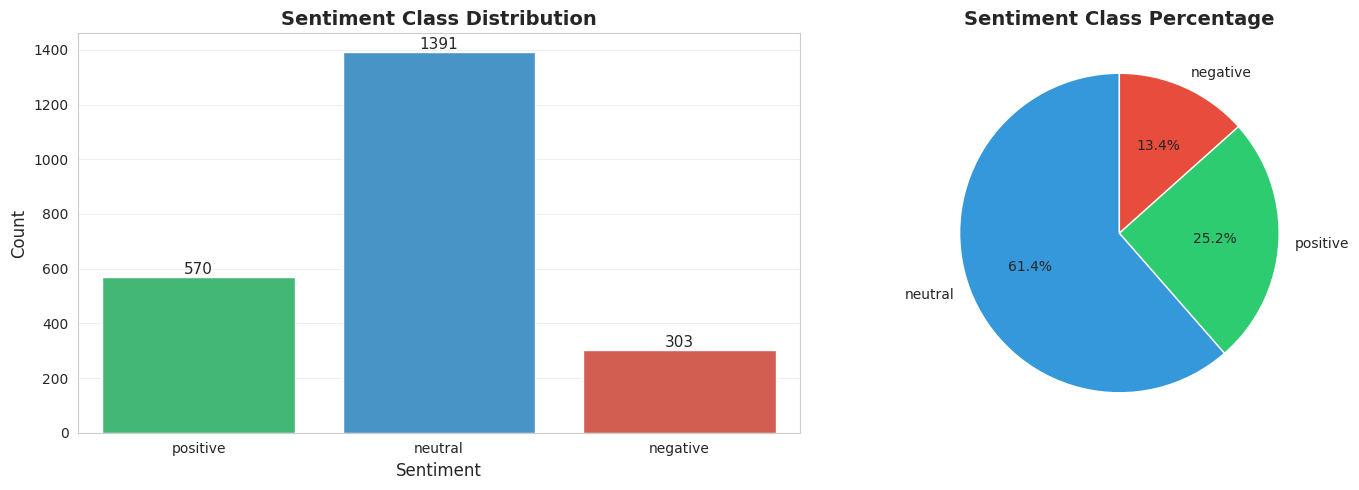

CLASS BALANCE STATISTICS

Total sentences: 2264

Sentiment distribution:
  Positive: 570 (25.18%)
  Neutral: 1391 (61.44%)
  Negative: 303 (13.38%)

Class imbalance ratio (max/min): 4.59
⚠️  Warning: Significant class imbalance detected!


In [ ]:
# Class balance visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Count plot
sentiment_counts = df['sentiment'].value_counts()
colors = {'positive': '#2ecc71', 'neutral': '#3498db', 'negative': '#e74c3c'}
ax1 = sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative'],
                    palette=[colors['positive'], colors['neutral'], colors['negative']], ax=axes[0])
axes[0].set_title('Sentiment Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for p in ax1.patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11)

# Pie chart
axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
           colors=[colors[s] for s in sentiment_counts.index], startangle=90)
axes[1].set_title('Sentiment Class Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print statistics
print("="*80)
print("CLASS BALANCE STATISTICS")
print("="*80)
print(f"\nTotal sentences: {len(df)}")
print(f"\nSentiment distribution:")
for sentiment in ['positive', 'neutral', 'negative']:
    count = (df['sentiment'] == sentiment).sum()
    percentage = (count / len(df)) * 100
    print(f"  {sentiment.capitalize()}: {count} ({percentage:.2f}%)")

# Class imbalance ratio
min_class = sentiment_counts.min()
max_class = sentiment_counts.max()
imbalance_ratio = max_class / min_class
print(f"\nClass imbalance ratio (max/min): {imbalance_ratio:.2f}")
if imbalance_ratio > 2:
    print("⚠️  Warning: Significant class imbalance detected!")


### 4.2 Sample Sentences from Each Class


In [ ]:
# Display sample sentences from each sentiment class
print("="*80)
print("SAMPLE SENTENCES FROM EACH CLASS")
print("="*80)

for sentiment in ['positive', 'neutral', 'negative']:
    print(f"\n{'='*80}")
    print(f"{sentiment.upper()} SENTENCES (showing 5 random samples):")
    print(f"{'='*80}\n")
    samples = df[df['sentiment'] == sentiment].sample(5, random_state=42)
    for idx, row in samples.iterrows():
        print(f"{idx+1}. {row['sentence']}")
        print(f"   (Processed: {row['processed_text'][:100]}...)")
        print()


SAMPLE SENTENCES FROM EACH CLASS

POSITIVE SENTENCES (showing 5 random samples):

854. These measures are expected to produce annual cost savings of EUR 1.5 million starting in 2007 .
   (Processed: measures expected produce annual cost savings eur 15 million starting 2007...)

76. The last quarter was the best quarter of 2009 in net sales , and the operating margin rose to 12.2 % .
   (Processed: last quarter best quarter 2009 net sales operating margin rose 122...)

137. In the fourth quarter of 2009 , Orion 's net profit went up by 33.8 % year-on-year to EUR33m .
   (Processed: fourth quarter 2009 orion net profit went 338 yearonyear eur33m...)

466. Operating profit improved by 44.0 % to ER 4.7 mn from EUR 3.3 mn in 2004 .
   (Processed: operating profit improved 440 er 47 mn eur 33 mn 2004...)

888. Tiimari Latvian representative Ineta Zaharova said that the company earned LVL 122,000 in 2005 profit , which is 20 times more that in 2004 .
   (Processed: tiimari latvian representat

### 4.3 Text Length Distribution Analysis


In [ ]:
# Calculate length statistics
length_stats = df.groupby('sentiment').agg({
    'original_length': ['mean', 'median', 'std', 'min', 'max'],
    'token_count': ['mean', 'median', 'std', 'min', 'max']
}).round(2)

print("="*80)
print("TEXT LENGTH STATISTICS BY SENTIMENT")
print("="*80)
print(length_stats)


TEXT LENGTH STATISTICS BY SENTIMENT
          original_length                        token_count                   \
                     mean median    std min  max        mean median   std min   
sentiment                                                                       
negative           126.38  114.0  54.44  37  296       14.60   13.0  6.25   4   
neutral            117.87  107.0  56.61   9  315       11.63   11.0  5.92   0   
positive           129.60  122.0  55.39  36  272       14.55   13.0  6.45   3   

               
          max  
sentiment      
negative   32  
neutral    45  
positive   33  


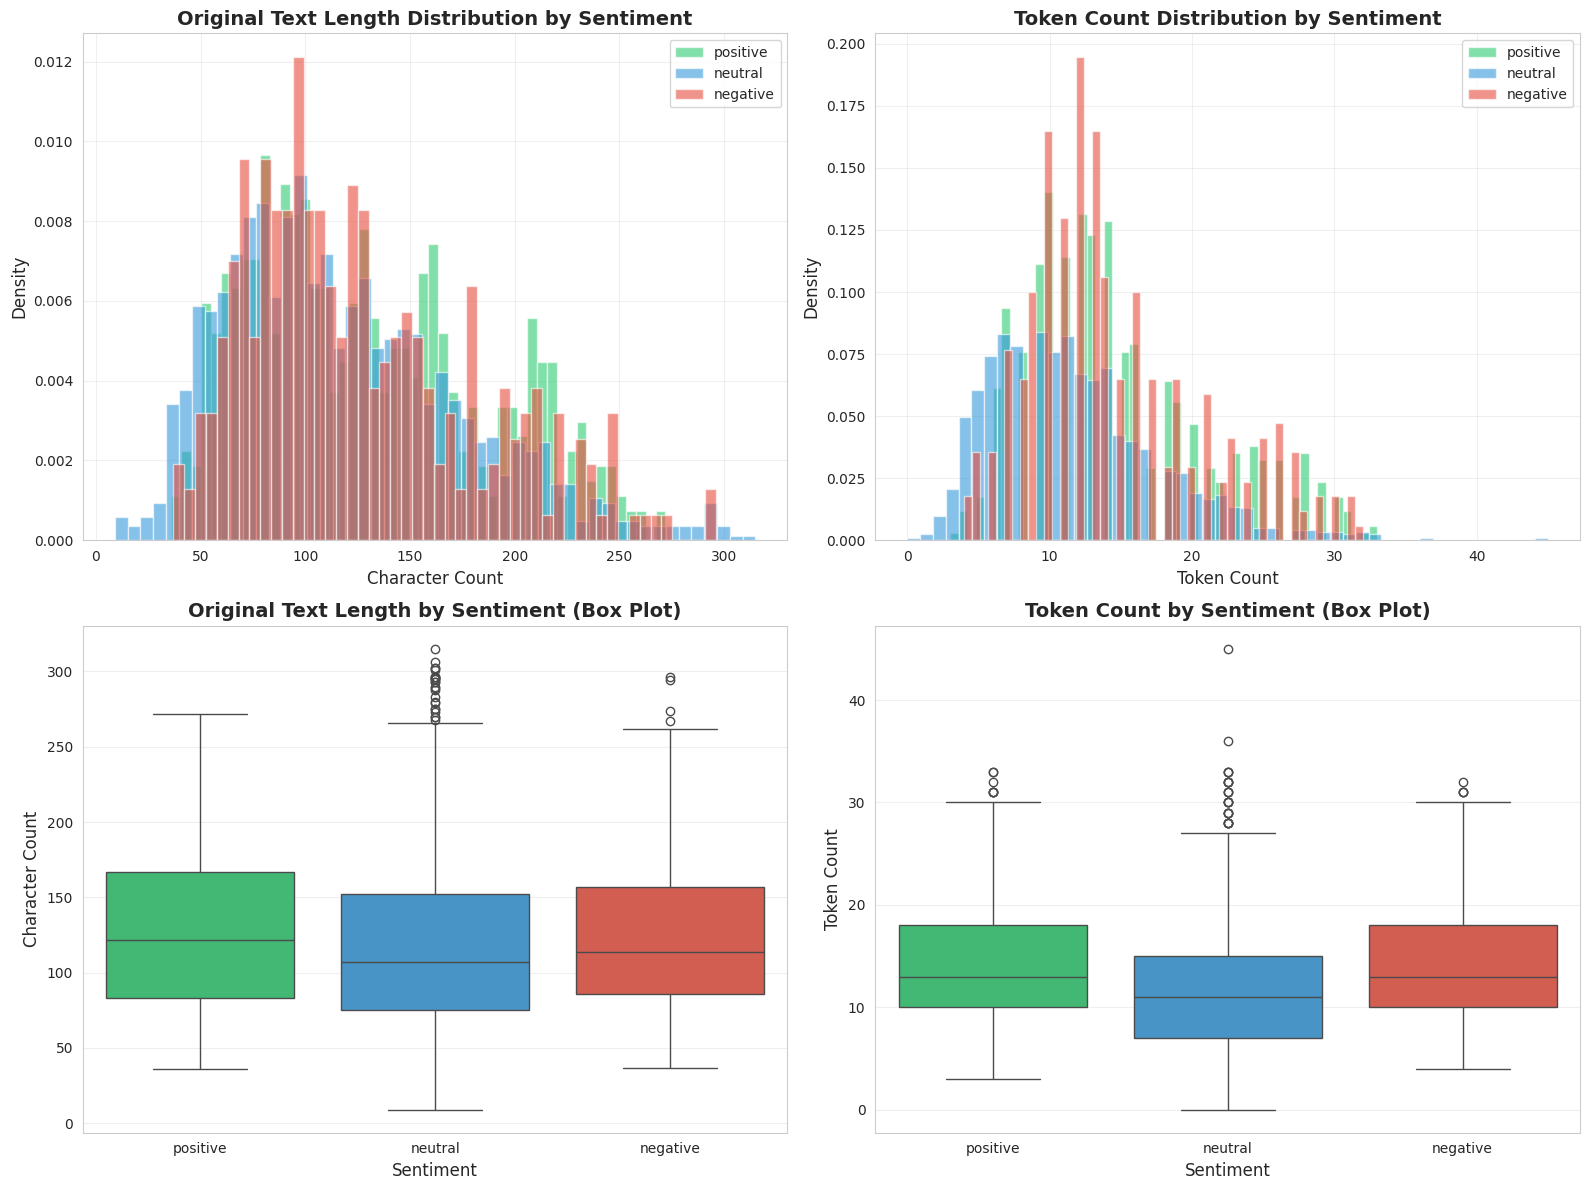

In [ ]:
# Visualize length distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Original text length distribution
ax1 = axes[0, 0]
for sentiment in ['positive', 'neutral', 'negative']:
    data = df[df['sentiment'] == sentiment]['original_length']
    ax1.hist(data, bins=50, alpha=0.6, label=sentiment, color=colors[sentiment], density=True)
ax1.set_title('Original Text Length Distribution by Sentiment', fontsize=14, fontweight='bold')
ax1.set_xlabel('Character Count', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

# Token count distribution
ax2 = axes[0, 1]
for sentiment in ['positive', 'neutral', 'negative']:
    data = df[df['sentiment'] == sentiment]['token_count']
    ax2.hist(data, bins=50, alpha=0.6, label=sentiment, color=colors[sentiment], density=True)
ax2.set_title('Token Count Distribution by Sentiment', fontsize=14, fontweight='bold')
ax2.set_xlabel('Token Count', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

# Box plot for original length
ax3 = axes[1, 0]
sns.boxplot(data=df, x='sentiment', y='original_length',
            order=['positive', 'neutral', 'negative'],
            palette=[colors['positive'], colors['neutral'], colors['negative']], ax=ax3)
ax3.set_title('Original Text Length by Sentiment (Box Plot)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Sentiment', fontsize=12)
ax3.set_ylabel('Character Count', fontsize=12)
ax3.grid(axis='y', alpha=0.3)

# Box plot for token count
ax4 = axes[1, 1]
sns.boxplot(data=df, x='sentiment', y='token_count',
            order=['positive', 'neutral', 'negative'],
            palette=[colors['positive'], colors['neutral'], colors['negative']], ax=ax4)
ax4.set_title('Token Count by Sentiment (Box Plot)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Sentiment', fontsize=12)
ax4.set_ylabel('Token Count', fontsize=12)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Summary statistics
print("="*80)
print("OVERALL LENGTH STATISTICS")
print("="*80)

print("\nOriginal Text Length (characters):")
print(f"  Mean: {df['original_length'].mean():.2f}")
print(f"  Median: {df['original_length'].median():.2f}")
print(f"  Std: {df['original_length'].std():.2f}")
print(f"  Min: {df['original_length'].min()}")
print(f"  Max: {df['original_length'].max()}")

print("\nToken Count (after preprocessing):")
print(f"  Mean: {df['token_count'].mean():.2f}")
print(f"  Median: {df['token_count'].median():.2f}")
print(f"  Std: {df['token_count'].std():.2f}")
print(f"  Min: {df['token_count'].min()}")
print(f"  Max: {df['token_count'].max()}")

# Show distribution percentiles
print("\nToken Count Percentiles:")
percentiles = [25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = np.percentile(df['token_count'], p)
    print(f"  {p}th percentile: {value:.2f} tokens")


OVERALL LENGTH STATISTICS

Original Text Length (characters):
  Mean: 121.96
  Median: 111.00
  Std: 56.24
  Min: 9
  Max: 315

Token Count (after preprocessing):
  Mean: 12.77
  Median: 12.00
  Std: 6.26
  Min: 0
  Max: 45

Token Count Percentiles:
  25th percentile: 8.00 tokens
  50th percentile: 12.00 tokens
  75th percentile: 16.00 tokens
  90th percentile: 22.00 tokens
  95th percentile: 25.00 tokens
  99th percentile: 30.37 tokens


### 4.4 Additional Dataset Insights


In [ ]:
# Check for missing values
print("="*80)
print("DATA QUALITY CHECKS")
print("="*80)
print(f"\nMissing values:")
print(df.isnull().sum())

print(f"\n\nEmpty sentences:")
empty_sentences = df[df['sentence'].str.strip() == '']
print(f"  Count: {len(empty_sentences)}")

print(f"\n\nDuplicate sentences:")
duplicate_sentences = df[df.duplicated(subset='sentence', keep=False)]
print(f"  Count: {len(duplicate_sentences)}")
if len(duplicate_sentences) > 0:
    print(f"\nSample duplicates:")
    print(duplicate_sentences[['sentence', 'sentiment']].head(10))

# Check sentiment label consistency
print(f"\n\nUnique sentiment labels: {df['sentiment'].unique().tolist()}")
print(f"Expected labels: ['positive', 'neutral', 'negative']")


DATA QUALITY CHECKS

Missing values:
sentence            0
sentiment           0
processed_text      0
tokens              0
token_count         0
original_length     0
processed_length    0
dtype: int64


Empty sentences:
  Count: 0


Duplicate sentences:
  Count: 10

Sample duplicates:
                                               sentence sentiment
518   The issuer is solely responsible for the conte...   neutral
519   The issuer is solely responsible for the conte...   neutral
625   The report profiles 614 companies including ma...   neutral
626   The report profiles 614 companies including ma...   neutral
928   Ahlstrom 's share is quoted on the NASDAQ OMX ...   neutral
929   Ahlstrom 's share is quoted on the NASDAQ OMX ...   neutral
1026  SSH Communications Security Corporation is hea...   neutral
1027  SSH Communications Security Corporation is hea...   neutral
1408  The company serves customers in various indust...   neutral
1409  The company serves customers in various indus

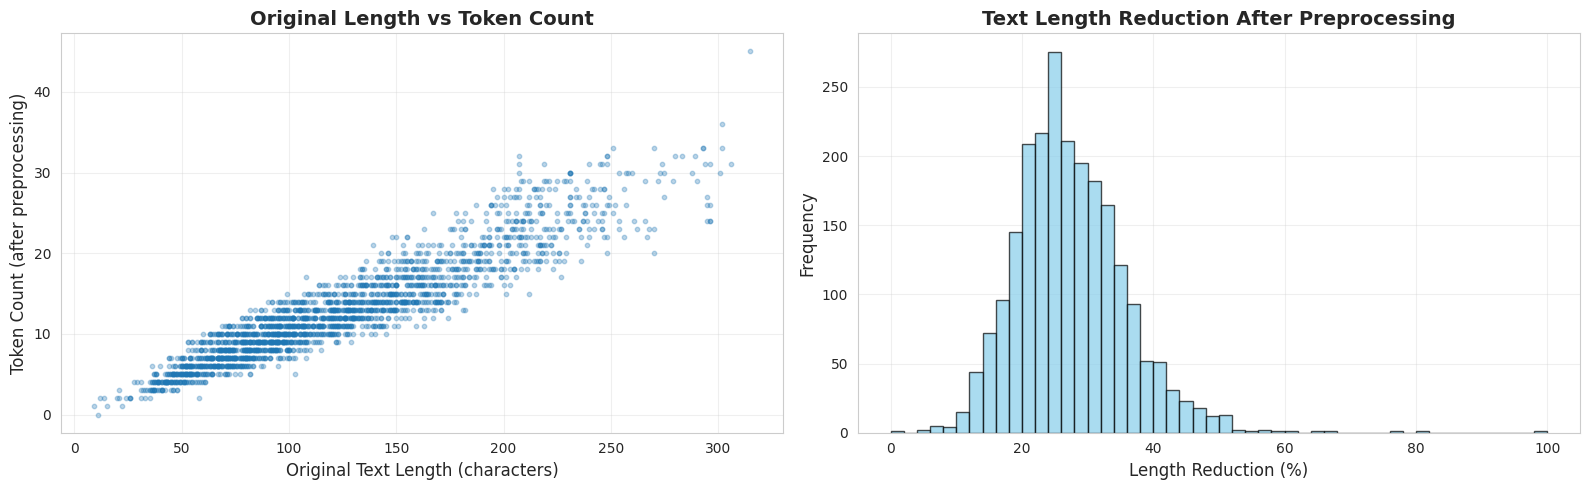

Average length reduction after preprocessing: 27.37%


In [ ]:
# Compare original vs processed text lengths
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scatter plot: original length vs token count
axes[0].scatter(df['original_length'], df['token_count'], alpha=0.3, s=10)
axes[0].set_xlabel('Original Text Length (characters)', fontsize=12)
axes[0].set_ylabel('Token Count (after preprocessing)', fontsize=12)
axes[0].set_title('Original Length vs Token Count', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Length reduction after preprocessing
length_reduction = ((df['original_length'] - df['processed_length']) / df['original_length']) * 100
axes[1].hist(length_reduction, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1].set_xlabel('Length Reduction (%)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Text Length Reduction After Preprocessing', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average length reduction after preprocessing: {length_reduction.mean():.2f}%")


## Step 5: Save Preprocessed Dataset

Save the preprocessed dataset for use in subsequent tasks.


In [ ]:
# Save preprocessed dataset
output_file = 'preprocessed_dataset.csv'

# Create a clean version for saving (without token lists to reduce file size)
df_save = df[['sentence', 'processed_text', 'sentiment', 'token_count', 'original_length', 'processed_length']].copy()
df_save.to_csv(output_file, index=False, encoding='utf-8')

print(f"Preprocessed dataset saved to: {output_file}")
print(f"Saved {len(df_save)} rows")
print(f"\nFirst few rows of saved dataset:")
df_save.head()


Preprocessed dataset saved to: preprocessed_dataset.csv
Saved 2264 rows

First few rows of saved dataset:


,sentence,processed_text,sentiment,token_count,original_length,processed_length
0,"According to Gran , the company has no plans t...",according gran company plans move production r...,neutral,10,127,76
1,"For the last quarter of 2010 , Componenta 's n...",last quarter 2010 componenta net sales doubled...,positive,19,193,124
2,"In the third quarter of 2010 , net sales incre...",third quarter 2010 net sales increased 52 eur ...,positive,16,125,85
3,Operating profit rose to EUR 13.1 mn from EUR ...,operating profit rose eur 131 mn eur 87 mn cor...,positive,16,122,94
4,"Operating profit totalled EUR 21.1 mn , up fro...",operating profit totalled eur 211 mn eur 186 m...,positive,14,103,78


## Summary

### Task 1 Completed: Data Preprocessing & EDA

✅ **Dataset Loading**: Successfully loaded Financial Phrase Bank dataset  
✅ **Text Preprocessing**: Implemented lowercase conversion, punctuation removal, tokenization, and stopword removal  
✅ **Class Balance Analysis**: Analyzed and visualized sentiment distribution  
✅ **Sample Sentences**: Displayed examples from each sentiment class  
✅ **Length Distribution**: Analyzed text length statistics and distributions  
✅ **Data Quality Checks**: Verified data integrity and identified any issues  

### Key Findings:
- **Dataset size**: {len(df)} sentences
- **Class distribution**: {df['sentiment'].value_counts().to_dict()}
- **Average text length**: {df['original_length'].mean():.1f} characters
- **Average token count**: {df['token_count'].mean():.1f} tokens after preprocessing

### Next Steps:
- Proceed to **Task 2: LDA Topic Modeling**
- Use the preprocessed dataset for topic modeling analysis


### Download Files (Google Colab Only)

If running in Google Colab, download the preprocessed dataset to your computer:


In [ ]:
# Download preprocessed dataset (Google Colab only)
try:
    from google.colab import files
    files.download(output_file)
    print(f"✓ Downloaded: {output_file}")
except ImportError:
    print("Not in Google Colab. File is saved locally.")
except Exception as e:
    print(f"Note: {e}")
    print("If you're in Colab and want to download, run: files.download('preprocessed_dataset.csv')")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded: preprocessed_dataset.csv


In [ ]:
# Final summary
print("="*80)
print("TASK 1 COMPLETION SUMMARY")
print("="*80)
print(f"\n✅ Dataset loaded: {len(df)} sentences")
print(f"✅ Preprocessing completed: All sentences processed")
print(f"✅ Class balance analyzed: {df['sentiment'].value_counts().to_dict()}")
print(f"✅ Length statistics computed")
print(f"✅ Sample sentences displayed for each class")
print(f"✅ Preprocessed dataset saved to: {output_file}")
print("\n" + "="*80)
print("READY FOR TASK 2: LDA Topic Modeling")
print("="*80)
